<a id="stepSTART"></a>
**Проект**: Мобильное приложение с элементами социальной сети, маркетплейса, объединяющее взаимодействие 3 сегментов аудитории

**Контекст**: 
На платформе действует закрытый клуб экспертов, участники которого регулярно размещают и продвигают собственные мероприятия.От качества описания и оформления карточки мероприятия напрямую зависит, как оно воспринимается аудиторией — и, в конечном итоге, насколько эффективно конвертируется просмотр в бронирование, а это является конечной целью эксперта и влияет на решение его задачи.

А рекомендации (“добавляйте отзывы”, “описывайте результат”, “делайте призыв к действию”) воспринимаются как нечто само-собой очевидные. 
И теряют вес без реальных доказательств.

Экспертному клубу важно опираться не на ощущения, а на данные — понимать, какие элементы в описании мероприятия делают больший вклад в бронирование мероприятия.

**Задача**: 

Подготовить материал для клуба экспертов, который покажет:

- Какие блоки в карточке мероприятия делают больший вклад в бронирование
  
[Ключевые выводы и рекомендации](#step9)

**Разделы исследования** <a id='stepend'></a>


1-3. [Импорт необходимых библиотек и формирование основных датафреймов](#step1)</n>

4. [Формирование датафрейма для применения критерия Хи-квадрат и регрессии](#step2)</n>

5. [Формирование датафрейма с описанием мероприятий](#step3)</n>

6. [Формирование датафрейма с критериями](#step4)</n>

7. [Визуализация заполнения описания по критериям и результаты](#step5)</n>

8. [Построение модели без поведенчеких факторов (линейная регрессия) + вывод](#step6)</n>

9. [Проверка связи между двумя категориальными переменными (Хи-квадрат) + вывод](#step7)</n>

10. [Сила влияния визита в карточку эксперта на бронирование](#step8)</n>

11. [Ключевые выводы и рекомендации](#step9)</n>

### `1 - 3. Импорт необходимых библиотек и формирование основных датафреймов` <a id="step1"></a>

In [1]:
# 1. Загрузим необходимые для работы библиотеки

import json
import pandas as pd
import re
import mysql.connector
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
# pd.set_option("display.max_rows", 150)

In [2]:
# 2. Сформируем основной датафрейм

with open("C:/Users/ASUS/Desktop/gheets/events/events.json", "r", encoding="utf-8-sig") as f:
    main_tab = json.load(f)

main_tab = pd.json_normalize(main_tab["data"])
main_tab = main_tab.rename(columns={"event_name": "event_type"})

# преобразуем данные в столбце с json в словарь
def try_parse(x):
    try:
        return json.loads(x)
    except:
        return {}
# сформируем столбец, в котором будет словарь из json
main_tab["event_json_parsed"] = main_tab["event_json"].apply(try_parse)

# сформируем из словарей столцы для таблицы
event_details = pd.json_normalize(main_tab["event_json_parsed"])

# создадим список желаемых колонок
desired_columns = ["space", 
                   "section", 
                   "screen", 
                   "object", 
                   "object_name", 
                   "event_id", 
                   "event_name"]

# оставим только те колонки, которые нужны
available_cols = [col for col in desired_columns if col in event_details.columns]

event_details = event_details[available_cols]

# удалим ненужные колонки и добавим к events - event_details
main_tab = pd.concat([main_tab.drop(columns=["event_json", 
                                             "event_json_parsed",
                                             "event_timestamp"]), event_details], axis=1)

# преобразуем столбец profile_id и достанем только цифры
main_tab["profile_id"] = main_tab["profile_id"].astype(str).str.extract(r"(\d+)")

# преобразуем столбец в дату
main_tab["event_datetime"] = pd.to_datetime(main_tab["event_datetime"])

main_tab = main_tab.query('space == "events"')
main_tab = main_tab[~main_tab["event_type"].isin(["share", "reject"])]

In [3]:
main_tab.head(2)

,appmetrica_device_id,profile_id,session_id,event_type,event_datetime,space,section,screen,object,object_name,event_id,event_name
61,4787503539448529407,9924762,10000000800,view,2025-06-29 09:21:29,events,about_event,about_event,screen,NaN,19723,Курс для женщин ВЕЛИКАЯ!
63,4787503539448529407,9924762,10000000801,view,2025-06-29 11:32:18,events,about_event,about_event,screen,NaN,19723,Курс для женщин ВЕЛИКАЯ!


In [4]:
# 3. Сформируем датафрейм с данными из Базы данных
events = main_tab.copy()
engine = create_engine('mysql+mysqlconnector:come_on_dude')

# сделаем SQL-запрос к БД
query = """SELECT events.event_id,
                  events.author_id,
                  users.status AS org_status
             FROM (SELECT id AS event_id,
                          format,
                          type,
                          price,
                          CASE 
                              WHEN withSpacePass = 0 THEN 'Нет'
                              WHEN withSpacePass = 1 THEN 'Да'
                              ELSE 'не определено'
                          END AS pass_status,
                          authorId AS author_id
                     FROM `come_on_dude`.activity AS activity) AS events
                  LEFT JOIN
                  (SELECT id AS user_id,
                          CASE 
                              WHEN clubMemberStatus = "MEMBER" THEN 'Герой'
                              WHEN clubMemberStatus = "LEAD" THEN 'Житель'
                              WHEN clubMemberStatus IN ("EXPERT", "EXPERT_PRO") THEN 'Эксперт'
                              WHEN clubMemberStatus = "AMBASSADOR" THEN 'Амбассадор'
                              WHEN clubMemberStatus = "GUEST" THEN 'Гость'
                              ELSE 'не определено'
                          END AS status
                    FROM `come_on_dude`.users) AS users
             ON events.author_id = users.user_id"""

# выполним запрос и загрузим результатаы в DataFrame
events_bd = pd.read_sql(query, engine)
events_bd["event_id"] = events_bd["event_id"].astype(str)

# соеденим датафреймы с AppMetrica и Базой данных
events = events.merge(events_bd, on="event_id", how="left")

# уберем данные просмотров и бронирований пользователей на свои же мероприятия
events = events[events["profile_id"] != events["author_id"]]

# уберем данные мероприятиям Героев
events = events.query('org_status != "Герой"')

In [5]:
events.head(3)

,appmetrica_device_id,profile_id,session_id,event_type,event_datetime,space,section,screen,object,object_name,event_id,event_name,author_id,org_status
0,4787503539448529407,9924762,10000000800,view,2025-06-29 09:21:29,events,about_event,about_event,screen,NaN,19723,Курс для женщин ВЕЛИКАЯ!,9924762,Амбассадор
1,4787503539448529407,9924762,10000000801,view,2025-06-29 11:32:18,events,about_event,about_event,screen,NaN,19723,Курс для женщин ВЕЛИКАЯ!,9924762,Амбассадор
2,4787503539448529407,9924762,10000000802,view,2025-06-29 11:56:37,events,about_event,about_event,screen,NaN,19723,Курс для женщин ВЕЛИКАЯ!,9924762,Амбассадор


### `4. Сформируем датафрейм для применения критерия Хи-квадрат и регрессии` <a id="step2"></a>

In [6]:
# 4.1 Сформируем датайрейм с данными по переходам в карточку эксперта
events_funnel = events.copy()
events_funnel = events_funnel.drop(columns=["space", 
                                            "section", 
                                            "screen", 
                                            "appmetrica_device_id", 
                                            "author_id", 
                                            "org_status", 
                                            "event_name"])

# уникальные просмотры
views_event = events_funnel.copy()
views_event = events_funnel.query("event_type == 'view'")[['profile_id', 'event_id']].drop_duplicates()

# уникальные клики на бронирование
bookings_event = events_funnel.copy()
bookings_event = events_funnel.query("event_type == 'click' and object_name == 'booking'")[['profile_id', 'event_id']].drop_duplicates()
bookings_event['booking'] = True

# уникальные клики на переход к эксперту
experts_event = events_funnel.copy()
experts_event = events_funnel.query("event_type == 'click' and object_name == 'expert_go'")[['profile_id', 'event_id']].drop_duplicates()
experts_event['expert'] = True

# объединение с просмотрами
views_event = views_event.merge(bookings_event, on=['profile_id', 'event_id'], how='left') \
                .merge(experts_event, on=['profile_id', 'event_id'], how='left')

# заполняем NaN флагами False
views_event['booking'] = np.where(views_event['booking'].isna(), False, True)
views_event['expert'] = np.where(views_event['expert'].isna(), False, True)

# категоризация поведения
def classify(row):
    if row['booking'] and row['expert']:
        return 'expert_booking_yes' # пользователь перешёл к организатору, и записался
    elif row['expert']:
        return 'expert_booking_no' # пользователь перешёл к организатору, и не записался
    elif row['booking']:
        return 'no_expert_booking' # пользователь не переходил к организатору, и записался
    else:
        return 'only_view' # пользователь не переходил к организатору, и не записался (просто посмотрел)

views_event['category'] = views_event.apply(classify, axis=1)

# подсчёт по категориям
category_counts = views_event.pivot_table(index='event_id',
                                          columns='category',
                                          values='profile_id',
                                          aggfunc='nunique',
                                          fill_value=0).reset_index()

# общее число уникальных просмотров
total_views = views_event.groupby('event_id')['profile_id'].nunique().reset_index().rename(columns={'profile_id': 'views'})

# объединение итоговой таблицы
events_funnel = total_views.merge(category_counts, on='event_id', how='left').fillna(0)

# переупорядочим столбцы
events_funnel = events_funnel[['event_id', 'views',
                               'only_view',
                               'expert_booking_yes',
                               'expert_booking_no',
                               'no_expert_booking']]


In [7]:
# 4.2 Посмотрим характеристики получившегося датафрейма
column_sums = events_funnel.sum(numeric_only=True)
column_sums

views                 11526
only_view              9751
expert_booking_yes      143
expert_booking_no       702
no_expert_booking       930
dtype: int64

In [8]:
# 4.3 Создадим агрегирующую колонку по бронированиям для использования в регрессии
events_funnel['bookings_all'] = events_funnel['expert_booking_yes'] + events_funnel['no_expert_booking']

In [9]:
events_funnel.head(5)

,event_id,views,only_view,expert_booking_yes,expert_booking_no,no_expert_booking,bookings_all
0,10019,1,1,0,0,0,0
1,10059,26,23,0,1,2,2
2,10069,26,24,0,1,1,1
3,10114,1,1,0,0,0,0
4,10154,16,15,0,0,1,1


### `5. Сформируем датафрейм c описанием мероприятий` <a id="step3"></a>

In [10]:
# 5.1 Сформируем датайрейм с данными по мероприятию (id-мероприятия, id-организатора, статус организатора, цена)

# подготовим список event_id
event_ids = events_funnel['event_id'].unique().tolist()
event_ids_str = ",".join(f"'{eid}'" for eid in event_ids)

# формирование датафрейма с данными из Базы данных
engine = create_engine('mysql+mysqlconnector:come_on_dude')

# 1 Сделаем SQL-запрос к БД
query = f"""
SELECT events.event_id,
       events.price,
       events.author_id,
       users.status AS org_status
  FROM (
        SELECT id AS event_id,
               price,
               authorId AS author_id
          FROM `come_on_dude`.activity AS activity
         WHERE id IN ({event_ids_str})
       ) AS events
       LEFT JOIN (
        SELECT id AS user_id,
               CASE 
                   WHEN clubMemberStatus = "MEMBER" THEN 'Герой'
                   WHEN clubMemberStatus = "LEAD" THEN 'Житель'
                   WHEN clubMemberStatus IN ("EXPERT", "EXPERT_PRO") THEN 'Эксперт'
                   WHEN clubMemberStatus = "AMBASSADOR" THEN 'Амбассадор'
                   WHEN clubMemberStatus = "GUEST" THEN 'Гость'
                   ELSE 'не определено'
               END AS status
         FROM `come_on_dude`.users
       ) AS users
    ON events.author_id = users.user_id
"""
# Выполнение запроса и загрузка результата в DataFrame
events_bd = pd.read_sql(query, engine)
events_bd["event_id"] = events_bd["event_id"].astype(str)

events_bd.head(5)

,event_id,price,author_id,org_status
0,649,NaN,936,Амбассадор
1,677,NaN,15058,Амбассадор
2,745,NaN,20353,Эксперт
3,782,NaN,56,Амбассадор
4,1022,NaN,36533,Гость


In [11]:
# 5.2 Формирование датафрейма с данными по описанию мероприятия 
engine = create_engine('mysql+mysqlconnector:come_on_dude')

# 1 Сделаем SQL-запрос к БД
query = f"""
SELECT id AS event_id,
       formattedDescription AS about
FROM `krugi-prod-social`.activity AS activity
WHERE id IN ({event_ids_str})
"""
# Выполнение запроса и загрузка результата в DataFrame
events_about = pd.read_sql(query, engine)

def clean_formatted_description(raw_text):
    try:
        if not isinstance(raw_text, str):
            return None

        # Заменяем \n на реальные переводы строки
        text = raw_text.replace('\\n', '\n').replace('\r', '')

        # Заменяем ссылки вида <a href="...">...</a> на саму ссылку
        text = re.sub(r'<a\s+href="([^"]+)">[^<]*</a>', r'\1', text)

        # Удалим лишние пробелы по краям
        return text.strip()

    except Exception as e:
        print(f"Ошибка при обработке formattedDescription: {e}")
        return None

# Применим к таблице
events_about['full_text'] = events_about['about'].apply(clean_formatted_description)

# Настроим отображение
pd.set_option('display.max_colwidth', None)

# Только нужные колонки
events_about = events_about[['event_id', 'full_text']]
#print(events_about['full_text'].iloc[1])
#Сохраним файл в директорию
#events_about.to_excel(r"C:\Users\ASUS\Downloads\events_about.xlsx", index=False)

In [12]:
# 5.3 Файл с описанием мероприятий для дальнейшего ранжирования
events_about.head(1)

,event_id,full_text
0,649,"Дорогие друзья, яркие личности и будущие миллионеры! 🌟\n\nНе пропустите эту уникальную возможность узнать, куда пропадают ваши деньги и как остановить этот безумный бег! 💸🏃‍♂️\n\nВсего за 3 часа проживем 25 лет условной семьи и выйдем на след финансовой стратегии, которая принесет вам благополучие и стабильность! 💼📈\n\nОлеся Юрьевна М. и ее команда экспертов ждут вас с открытыми объятиями (и знаниями) для того, чтобы вы смогли вырваться из кредитной ямы и стать настоящими финансовыми героями! 🦸‍♂️🦸‍♀️\n\nЯ, Олеся Мельникова, 18 лет помогаю людям защищать жизнь, здоровье, имущество с помощью страхования.\n\nБолее 3000 моих клиентов знают, что страховой полис – это безопасность и гарантия собственного финансового благополучия и будущего вашей семьи. \n\nПрямо сейчас общая сумма страховой защиты моих клиентов составляет \n200 000 000 р.\n\nЗа всё время работы я помогла получить страховых выплат на сумму 100 млн. р.\n\nПри этом на покупке страховой защиты мои клиенты сэкономили более 700 тыс. р.\n\nСотрудничество со мной – это не просто «купил и забыл», а реальная помощь в трудной ситуации. Если для обычного человека болезнь или несчастный случай – настоящая проблема, то для тех, у кого есть страховой полис и моё сопровождения – это всего лишь один звонок Олесе, которая всё сделает за них.\n\n\nУчастие в игре ""Управляй семейным капиталом"" стоит всего лишь небольшого взноса, но знания, которые вы получите, будут намного ценнее! 💡💰\n\nТак что не сомневайтесь, присоединяйтесь к нам и становитесь частью этой захватывающей игры!\n\nИ помните, друзья, финансовая независимость - это не только крутые машины и яхты, но и спокойствие, свобода и возможность съездить на отпуск хоть каждый месяц! 🌴😎\n\nОтзывы участников – https://t.me/+UPkuR0xxBuNJNNO9\n\nhttps://game.bitrix24site.ru/ обязательная регистрация"


### `6. Сформируем датафрейм с критериями описания мероприятия` <a id="step4"></a>

In [13]:
# 6.1 Загрузим датафрейм с криетриями по каждому мероприятию
events_rate = pd.read_excel(r'C:/Users/ASUS/Desktop/gheets/events/events_rate.xlsx')

In [14]:
# 6.2. Оставляем только нужные колонки
columns = [
    'event_id',
    'Перечислена тема / программа',
    'Кому подходит / аудитория',
    'Результат для участника',
    'Уникальность подхода эксперта',
    'Регалии эксперта',
    'Формат мероприятия',
    'Особенности мероприятия',
    'Отзывы участников',
    'Призыв к действию',
    'Итого'
]
events_rate = events_rate[columns]

new_names = {
    'event_id': 'event_id',
    'Перечислена тема / программа': 'topic',
    'Кому подходит / аудитория': 'audience',
    'Результат для участника': 'results',
    'Уникальность подхода эксперта': 'expert_approach',
    'Регалии эксперта': 'expert_regalia',
    'Формат мероприятия': 'format',
    'Особенности мероприятия': 'event_features',
    'Отзывы участников': 'feedback',
    'Призыв к действию': 'cta',
    'Итого': 'total'
}

events_rate = events_rate.rename(columns=new_names)
events_rate['event_id'] = events_rate['event_id'].astype('object')
events_rate_main = events_rate.copy()


columns_events_rate_main = [
    'event_id',
    'total'
]
events_rate_main = events_rate_main[columns_events_rate_main]
events_rate['event_id'] = events_rate['event_id'].astype('object')

In [15]:
events_rate.head(5)

,event_id,topic,audience,results,expert_approach,expert_regalia,format,event_features,feedback,cta,total
0,649,0,0,1,0,1,1,1,1,1,6
1,677,0,0,0,0,1,1,0,0,1,3
2,745,1,0,0,0,1,0,0,0,0,2
3,782,0,0,0,0,1,0,1,0,0,2
4,1022,1,0,1,0,1,1,1,0,0,5


### `7. Визуализация заполнения описания по критериям и результаты` <a id="step5"></a>

format             60.2
expert_regalia     50.3
event_features     46.3
results            42.2
topic              39.4
cta                22.0
audience           16.3
feedback           10.8
expert_approach     2.8
dtype: float64


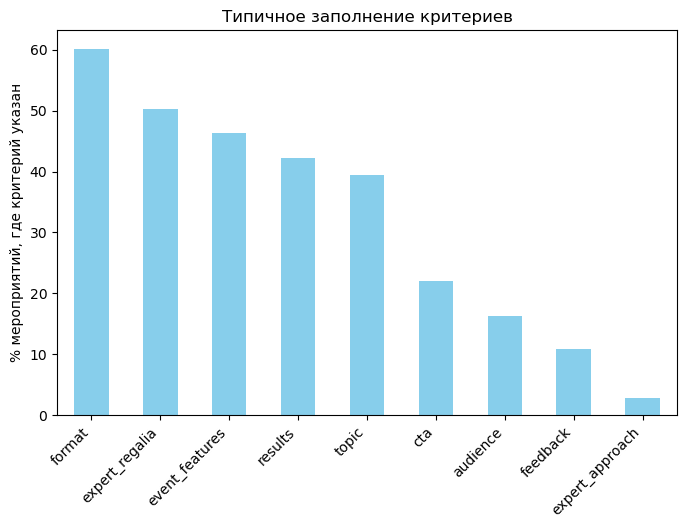

In [16]:
# убираем служебные колонки
criteria = events_rate.drop(columns=['event_id','total'])

# считаем среднее (т.к. 0/1 → это доля)
fill_rate = criteria.mean().sort_values(ascending=False)

# переводим в %
fill_rate_percent = (fill_rate * 100).round(1)

print(fill_rate_percent)

# визуализация
plt.figure(figsize=(8,5))
fill_rate_percent.plot(kind='bar', color='skyblue')
plt.ylabel('% мероприятий, где критерий указан')
plt.title('Типичное заполнение критериев')
plt.xticks(rotation=45, ha='right')
plt.show()

### Результат
* Формат мероприятия (format) в 60.2%
Формат указывают чаще всего.

* Регалии эксперта (expert_regalia) в 50.3%
Регалии эксперта пишут часто.

* Особенности мероприятия (event_features) в 46.3%
Особенности мероприятия описаны примерно в половине случаев. Сюда входит что-то дополнительное, например, — чек-лист, нетворкинг и прочее.

* Результаты для участников (results) в 42.2%
То, что связано с результатом для участника формулируется лишь в 4 из 10 описаниях. Хотя как ниже будет показано, это второй по важности

* Указание темы (topic) в 39.4%
Повтор темы в описании только в ~40% описаний. Не встречается элементов, которые бы коррелировали с заголовком.

* Призыв к действию (cta) в 22.0%
Призыв к действию встречается редко. 

* Кому подходит, аудитория мероприятия (audience) в 16.3%
Очень мало кто пишет для кого подходит.

* Отзывы (feedback) в 10.8%
Отзывы почти не встречаются, хотя это самый сильный фактор, об этом ниже. Даже цитата уже вносит вклад.

* Уникальность подхода эксперта	(expert_approach) в  2.8%
Почти никто раскрывает уникальность подхода эксперта в его деятельности. Хотя это третий по важности фактор, — об этом ниже

### Вывод
Сейчас эксперты в основном описывают “кто ведёт” (регалии) и “как проходит” (формат).
Но почти не отвечают на вопросы участника:

* “А что я получу?” (results),

* “Подходит ли это мне?” (audience),

* “Почему этот эксперт особенный?” (expert_approach),

* “Стоит ли доверять?” (feedback),

* “Что мне делать дальше?” (cta).

In [17]:
# 6.3 Сформируем итоговый датафрейм
events_funnel['event_id'] = events_funnel['event_id'].astype(str)
events_rate['event_id'] = events_funnel['event_id'].astype(str)
events_funnel = events_funnel.merge(events_rate, on=['event_id'], how='left')

### `8. Построение модели без поведенчеких факторов (линейная регрессия) + вывод` <a id="step6"></a>

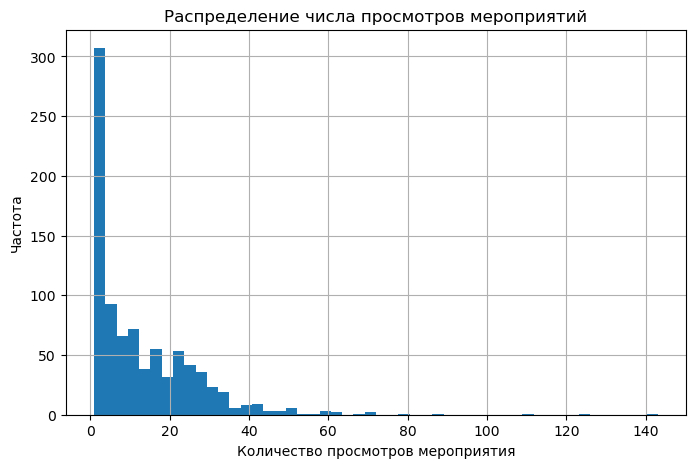

count    886.000000
mean      13.009029
std       14.705621
min        1.000000
25%        2.000000
50%        8.000000
75%       21.000000
max      143.000000
Name: views, dtype: float64

Квантили:
10%: 1
25%: 2
50%: 8
75%: 21
90%: 30


In [19]:
# 8.1 Построим гистограмму распределения просмотров.
# Выбере промежуток по числу просмотров

# Мероприятия с очень малым числом просмотров слишком случайны конверсии
# Мероприятия с очень большим числом просмотров могут быть аномалиями, и их структура бронирований может отличаться.
# Средние получаются — самые репрезентативные и повышают сделать честное сравнение текста.

plt.figure(figsize=(8,5))
events_funnel['views'].hist(bins=50)
plt.xlabel('Количество просмотров мероприятия')
plt.ylabel('Частота')
plt.title('Распределение числа просмотров мероприятий')
plt.grid(True)
plt.show()

# Посмотрим основные квантильные значения (медиану, 25/75 перцентиль, и т.д.)
print(events_funnel['views'].describe())
print('\nКвантили:')
for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
    print(f'{int(q*100)}%: {events_funnel["views"].quantile(q):.0f}')

Точность на тесте: 0.5454545454545454

Аналитика факторов (для презентации):

                 Коэффициент  Odds Ratio  Изменение шанса (%)
feedback               0.294       1.342                 34.2
results                0.286       1.331                 33.1
audience               0.027       1.028                  2.8
cta                   -0.044       0.957                 -4.3
expert_regalia        -0.079       0.924                 -7.6
event_features        -0.099       0.906                 -9.4
format                -0.216       0.806                -19.4
topic                 -0.221       0.802                -19.8
expert_approach       -0.282       0.754                -24.6


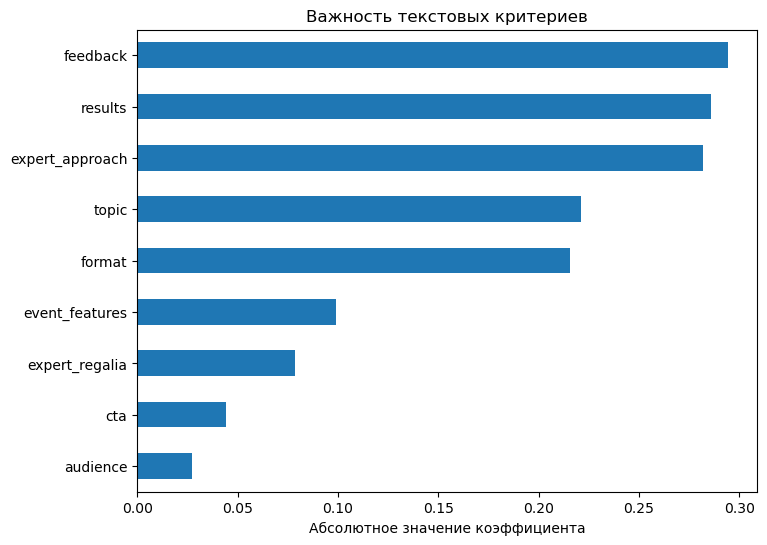

In [20]:
# 8.2 Модель только с критериями описания мероприятия, без поведенческих факторов

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 1. Загрузка и фильтрация.
# отсечь совсем “нулевые” события и те, которые слишком выбиваются по охвату.
df = events_funnel.copy()  # или pd.read_excel('events_criteria_clean.xlsx')
df = df[(df['views'] >= 8) & (df['views'] <= 30)].copy()

# 2. Укажем целевую переменная
df['target'] = (df['bookings_all'] > 0).astype(int)

# 3. Только текстовые признаки
features_text = [
    'topic', 'audience', 'results', 'expert_approach', 'expert_regalia',
    'format', 'event_features', 'feedback', 'cta'
]
X = df[features_text]
y = df['target']

# 4. Обучение модели, разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print('Точность на тесте:', model.score(X_test, y_test))

# 5. Интерпретация факторов.
# Вывод коэффициентов, ODDS RATIO и ПРОЦЕНТНОГО ИЗМЕНЕНИЯ
coef = pd.Series(model.coef_[0], index=features_text) # коэффициенты регрессии (насколько сильно каждый критерий влияет на вероятность бронирования).
odds_ratio = np.exp(coef) # коэффициенты в шансы
percent_change = (odds_ratio - 1) * 100 # во сколько % меняется вероятность, если признак есть

summary = pd.DataFrame({
    'Коэффициент': coef,
    'Odds Ratio': odds_ratio,
    'Изменение шанса (%)': percent_change
}).sort_values('Odds Ratio', ascending=False)

summary = summary.round({'Коэффициент': 3, 'Odds Ratio': 3, 'Изменение шанса (%)': 1})
print('\nАналитика факторов (для презентации):\n')
print(summary)

# 6. Визуализация важности
# Чем больше коэффициент по модулю, тем сильнее влияние критерия.
coef.abs().sort_values(ascending=True).plot(kind='barh', figsize=(8,6), title='Важность текстовых критериев')
plt.xlabel('Абсолютное значение коэффициента')
plt.show()

### Вывод
* Наибольший вклад в бронирование дают отзывы и описание результата для участника — фокусироваться нужно на них!
* Положительное значение = этот блок реально помогает!
* Отрицательное = этот блок сам по себе не отличает успешные мероприятия, это типа как "минимальный джентельменский набр"

feedback (отзывы):
+34% к шансам бронирования, если блок есть в описании.

results (результаты для участников):
+33% к шансам бронирования.

audience (кому подходит):
+3% (малое, но позитивное влияние).

cta (призыв), expert_regalia (регалии), event_features, format, topic, expert_approach:
от −4% до −25% — формально снижают шанс типа, но  
Это значит, что среди всех мероприятий наличие этих блоков не отличает успешные от неуспешных (часто встречаются у всех).



### `9. Проверка связи между двумя категориальными переменными (Хи-квадрат) + вывод` <a id="step7"></a>

Проверим, есть ли статистическая разница между пользователями, которые смотрят карточку эксперта и теми, кто нет (тест хи-квадрат).

In [21]:
# 9.1 Проведем тест хи-квадрат

# Суммируем по всем мероприятиям
observed = pd.DataFrame({
    'booking': [
        events_funnel['expert_booking_yes'].sum(),
        events_funnel['no_expert_booking'].sum()
    ],
    'no_booking': [
        events_funnel['expert_booking_no'].sum(),
        events_funnel['only_view'].sum()
    ]
}, index=['viewed_expert', 'not_viewed_expert'])

# Посмотрим таблицу
print(observed)
print()

chi2, p_value, dof, expected = chi2_contingency(observed)

# Формулируем вывод точнее
if p_value < 0.05:
    conclusion = (
        "Обнаружена статистически значимая связь между "
        "просмотром профиля эксперта и фактом бронирования."
    )
else:
    conclusion = (
        "Не обнаружено статистически значимой связи между "
        "просмотром профиля эксперта и фактом бронирования."
    )

print(f"χ² = {chi2:.4f}\np-value = {p_value:.4f}\nВывод: {conclusion}")

                   booking  no_booking
viewed_expert          143         702
not_viewed_expert      930        9751

χ² = 61.6387
p-value = 0.0000
Вывод: Обнаружена статистически значимая связь между просмотром профиля эксперта и фактом бронирования.


### Вывод
Между фактом просмотра профиля эксперта и бронированием мероприятия существует значимая связь (p-value < 0.001).

Пользователи, которые перешли в карточку эксперта, бронируют мероприятие в 2 раза чаще по сравнению с теми, кто этого не сделал.

Но тут важно, что сам по себе переход к эксперту может быть не причиной, а следствием уже сформированного интереса.

16.9% - конверсия в бронирование, если посмотрели профиль
8.7% - конверсия в бронирование, если не смотрели профиль

Профиль важен в пользовательском пути, по крайней мере как точка доверия или подтверждения намерения.

### `10. Сила влияния визита в карточку эксперта на бронирование` <a id="step8"></a>

Уточним силу влияния этого фактора на бронирование

Точность на тестовой выборке: 0.4935064935064935

Аналитика факторов (флаг перехода к эксперту):

                   Коэффициент  Odds Ratio  Изменение шанса (%)
expert_card_visit        0.440       1.553                 55.3
results                  0.314       1.369                 36.9
feedback                 0.302       1.353                 35.3
audience                -0.007       0.993                 -0.7
cta                     -0.020       0.980                 -2.0
expert_regalia          -0.093       0.911                 -8.9
event_features          -0.098       0.907                 -9.3
format                  -0.198       0.820                -18.0
topic                   -0.243       0.784                -21.6
expert_approach         -0.314       0.731                -26.9


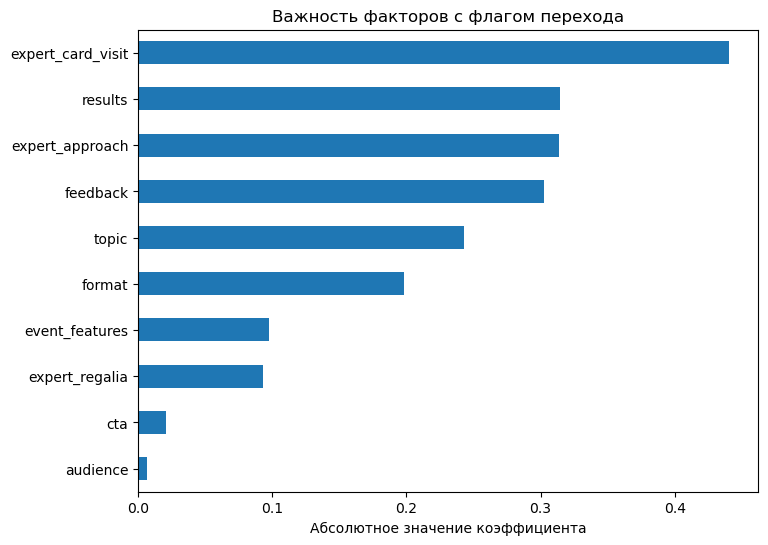

In [22]:
# 8.3 Модель только поведенческим фактором — переход на страницу эксперта
# Загрузка и фильтрация
df = events_funnel.copy()
df = df[(df['views'] >= 8) & (df['views'] <= 30)].copy()
df['target'] = (df['bookings_all'] > 0).astype(int)

# Новый бинарный признак
df['expert_card_visit'] = ((df['expert_booking_yes'] > 0) | (df['expert_booking_no'] > 0)).astype(int)

features = [
    'topic', 'audience', 'results', 'expert_approach', 'expert_regalia',
    'format', 'event_features', 'feedback', 'cta',
    'expert_card_visit'
]

X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print('Точность на тестовой выборке:', model.score(X_test, y_test))

# Аналитика факторов
coef = pd.Series(model.coef_[0], index=features)
odds_ratio = np.exp(coef)
percent_change = (odds_ratio - 1) * 100

summary = pd.DataFrame({
    'Коэффициент': coef,
    'Odds Ratio': odds_ratio,
    'Изменение шанса (%)': percent_change
}).sort_values('Odds Ratio', ascending=False)

summary = summary.round({'Коэффициент': 3, 'Odds Ratio': 3, 'Изменение шанса (%)': 1})
print('\nАналитика факторов (флаг перехода к эксперту):\n')
print(summary)

# Визуализация
coef.abs().sort_values(ascending=True).plot(kind='barh', figsize=(8,6), title='Важность факторов с флагом перехода')
plt.xlabel('Абсолютное значение коэффициента')
plt.show()

# Cам переход к эксперту является значимым фактором в принятии решения.
# Переход может быть не причиной, а следствием уже высокого интереса или доверия к эксперту
# Какчество карточки эксперта становится ключевым звеном в момент принятия решения

### Вывод
Если пользователь переходит в карточку эксперта, шанс, что он забронирует мероприятие, возрастает на 55% по сравнению с тем, кто не переходит.

Это подтверждает, что сам переход к эксперту является значимым фактором в принятии решения.

Но,переход может быть не причиной, а следствием уже высокого интереса или доверия к эксперту.

В любом случае, качество карточка эксперта это ключевое звено в момент принятия решения.

### `11. Результаты исследования и выводы` <a id="step9"></a>

#### 11.1 Заполнение описания
Большинство экспертов фокусируются на формате, регалиях и описании продукта — но не на эффекте для участника или социальной валидации. Сейчас эксперты в основном описывают “кто ведёт” (регалии) и “как проходит” (формат).
   
Но почти не отвечают на вопросы участника:

- “А что я получу?” (results),

* “Подходит ли это мне?” (audience),

* “Почему этот эксперт особенный?” (expert_approach),

* “Стоит ли доверять?” (feedback),

* “Что мне делать дальше?” (cta).


#### 11.2 Влияние критериев в описани на бронирование

Наличие отзывов в описании — оказывают наибольшее положительное влияние на бронирование. Мероприятия, в которых прописаны результаты для участников и есть отзывы, бронируют значительно чаще.При этом именно эти блоки заполняются реже других.

Топ 3 однозначных критерия по влиянию на бронирование:

| Повышение шансов на бронирование:  | Изменение шанса |
| ------------- |:-------------:|
| Отзывы участников      | +34.2%     |
| Результаты для участников      | +33.1%     |
| Кому подходит, аудитория      | +2.8%     |

Факторы, которые эксперты чаще всего упускают — отзывы и результат — оказывают наибольшее положительное влияние на бронирование.

Сместить фокус при оформлении карточки мероприятия:

Не на "о чём мероприятие", а на "что изменится для участника" и добавлять социальные доказательства (отзывы, впечатления)

#### 11.3 Влияние перехода в профиль эксперта на бронирование

Между просмотром профиля эксперта и бронированием мероприятия есть статистически значимая связь. Пользователи, которые знакомились с экспертом, бронировали в 2 раза чаще. Но,переход может быть не причиной, а следствием уже высокого интереса или доверия к эксперту.
Сам факт перехода к эксперту остаётся значимым. Он повышает шанс бронирования на 55%.

Пользователи, знакомящиеся с экспертом, склонны бронировать чаще.
Поэтому оформление профиля — это не “дополнение”, а часть воронки.